In [1]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#有中文出现的情况，需要u'内容'

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import scipy.stats as stats
from datum import *
import model
import sys

In [2]:
vali_list = []
test_list = []
base_vali_list = []
base_test_list = []

In [3]:
def select(top_num, vali, test):
    vali_abs = np.abs(vali)
    arg_sort = np.argsort(vali_abs)
    select_arg = arg_sort[-top_num:]
    print('minimum: {}'.format(vali[select_arg[0]]))
    select_vali = vali[select_arg]
    select_test = test[select_arg]
    true_test = np.abs(select_test)
    #true_test = np.nan_to_num(select_test * select_vali / np.abs(select_vali))
    print('mean: {}'.format(true_test.mean()))
    return true_test, select_arg

In [4]:
list_data = []
list_mod = []
for i in range(3):
    data = Datum('{}_{}_{}'.format(2006010120160101+i, 2016010120170101, 'year'))
    data.data_prepare()
    data.get_embedding()
    data.supervised_data_prepare()
    data.ic_prepare()
    list_data.append(data)

    reload(model)
    tf.reset_default_graph()
    mod = model.Model(1, '{}_{}_{}'.format(2006010120160101+i, 2016010120170101, 'year'))
    mod.data_initial(data)
    mod.data_split()
    mod.factor_network() 
    list_mod.append(mod)
    
    for j in range(3):
        model_num = j
        saver = tf.train.Saver(max_to_keep=50)
        data_dir = '/data/zhige_data/embedding_simpyear/'
        with tf.Session() as sess:
            saver.restore(sess, data_dir+'{}model_{}/logmodel.ckpt'.format(model_num, mod.param))
            rank_ic = np.zeros((mod.vali_test-mod.train_vali, 44, 4))
            embedding = mod.data.embedding[:len(mod.data.list_stocks), :]
            for count_day, day in enumerate(range(mod.train_vali,mod.vali_test)):#batch_num
                for fac_idx in range(44):
                    feature = mod.data.feature_data[:, day, fac_idx]
                    if feature.std() != 0:
                        feature = (feature-feature.min()) / (feature.max() - feature.min())
                    else:
                        continue
                    label = mod.data.ar_ic[:, day, 2]
                    feed_dict = {mod.embedding: embedding, mod.factor: feature, mod.factor_index: [fac_idx], mod.ic: label}
                    new_f, loss_val = sess.run([mod.new_f, mod.cost], feed_dict=feed_dict)
                    for ic_idx in range(4):
                        rank_ic[count_day, fac_idx, ic_idx] = stats.spearmanr(mod.data.ar_ic[:, day, ic_idx], new_f)[0]
            vali_ic_mean = rank_ic.mean(axis=0)[:, 2]
            vali_list.append(vali_ic_mean)

            rank_ic = np.zeros((mod.day_sample-mod.vali_test, 44, 4))
            embedding = mod.data.embedding[:len(mod.data.list_stocks), :]
            print('test: model:{}'.format(model_num))
            for count_day, day in enumerate(range(mod.vali_test, mod.day_sample)):#batch_num
                for fac_idx in range(44):
                    feature = mod.data.feature_data[:, day, fac_idx]
                    if feature.std() != 0:
                        feature = (feature-feature.min()) / (feature.max() - feature.min())
                    else:
                        continue
                    label = mod.data.ar_ic[:, day, 2]
                    feed_dict = {mod.embedding: embedding, mod.factor: feature, mod.factor_index: [fac_idx], mod.ic: label}
                    new_f, loss_val = sess.run([mod.new_f, mod.cost], feed_dict=feed_dict)
                    for ic_idx in range(4):
                        rank_ic[count_day, fac_idx, ic_idx] = stats.spearmanr(mod.data.ar_ic[:, day, ic_idx], new_f)[0]
            avg_ic = rank_ic.mean(axis=0)[:, 2]
            test_list.append(avg_ic)
            print(np.abs(avg_ic))
            print(np.abs(avg_ic).mean())         
    

INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/0model_2006010120160101_2016010120170101_year/logmodel.ckpt
test: model:0
[0.04970622 0.00774889 0.04739224 0.0696272  0.08608383 0.09092195
 0.08734872 0.08570742 0.0827265  0.04762662 0.09800316 0.04036924
 0.11193305 0.10607395 0.105058   0.09854697 0.05397226 0.08556143
 0.0348846  0.04408098 0.         0.08984549 0.08365846 0.09308335
 0.01793199 0.09093677 0.         0.05297695 0.07823122 0.05805393
 0.00216774 0.04916643 0.         0.07436967 0.06952886 0.07759437
 0.02670321 0.05349619 0.         0.04700381 0.07394347 0.06215675
 0.04655435 0.08129331]
0.06050158023783962
INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/1model_2006010120160101_2016010120170101_year/logmodel.ckpt
test: model:1
[0.08308335 0.00713272 0.06141685 0.06837774 0.09090937 0.08662425
 0.08718998 0.03404665 0.08924457 0.09135858 0.09854464 0.04041258
 0.11475158 0.10454241 0.10348031 0.10296634 0.06

In [5]:
rank_ic = np.zeros((mod.vali_test-mod.train_vali, 44, 4))
for count_day, day in enumerate(range(mod.train_vali,mod.vali_test)):#batch_num
    for fac_idx in range(44):
        feature = mod.data.feature_data[:, day, fac_idx]
        for ic_idx in range(4):
            rank_ic[count_day, fac_idx, ic_idx] = np.nan_to_num(stats.spearmanr(mod.data.ar_ic[:, day, ic_idx], feature)[0])
vali_ic_mean = rank_ic.mean(axis=0)[:, 2]
base_vali_list.append(vali_ic_mean)           

rank_ic = np.zeros((mod.day_sample-mod.vali_test, 44, 4))
for count_day, day in enumerate(range(mod.vali_test, mod.day_sample)):#batch_num
    for fac_idx in range(44):
        feature = mod.data.feature_data[:, day, fac_idx]
        for ic_idx in range(4):
            rank_ic[count_day, fac_idx, ic_idx] = np.nan_to_num(stats.spearmanr(mod.data.ar_ic[:, day, ic_idx], feature)[0])
avg_ic = rank_ic.mean(axis=0)[:, 2]
base_test_list.append(avg_ic)
print(np.abs(avg_ic))
print(np.abs(avg_ic).mean())             

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


[0.01570215 0.00946217 0.03806243 0.04046846 0.03887624 0.03681295
 0.04776479 0.04741044 0.03590629 0.03561715 0.05406    0.03797495
 0.08285912 0.08295273 0.07607425 0.07105155 0.04120249 0.03398427
 0.02662561 0.00605398 0.         0.0429759  0.04970019 0.06209276
 0.00665362 0.00753211 0.         0.00257618 0.00455414 0.01161567
 0.00213335 0.04767455 0.         0.01622448 0.02130751 0.02466987
 0.00560217 0.00774158 0.         0.01294015 0.01307541 0.01339721
 0.01406568 0.02282426]
0.02836997250833676


In [14]:
mean = 0
for i in range(9):
    select_fac, select_arg = select(10, vali_list[i], test_list[i])
    mean += select_fac.mean()
print(mean / 9)

minimum: -0.0595358048873
mean: 0.0945090085938
minimum: -0.0558001584086
mean: 0.0956004836224
minimum: -0.0565293631635
mean: 0.0963756938281
minimum: -0.0543016708201
mean: 0.0953614050938
minimum: -0.0568610266681
mean: 0.0965265088185
minimum: -0.0554837116241
mean: 0.0979304574158
minimum: -0.0564032061919
mean: 0.0956630809576
minimum: -0.0534970979995
mean: 0.0976615031402
minimum: -0.0560255167716
mean: 0.0978498800916
0.0963864468402


In [15]:
select_fac, select_arg = select(10, base_vali_list[-1], base_test_list[-1])

minimum: -0.0490438435058
mean: 0.0576817444592


# Visualized Weights

In [293]:
list_confidence = []
for i in range(3):
    data = Datum('{}_{}_{}'.format(2006010120160101+i, 2016010120170101, 'year'))
    data.data_prepare()
    data.get_embedding()

    reload(model)
    tf.reset_default_graph()
    mod = model.Model(1, '{}_{}_{}'.format(2006010120160101+i, 2016010120170101, 'year'))
    mod.data_initial(data)
    mod.factor_network()
    
    for j in range(3):
        model_num = j
        saver = tf.train.Saver(max_to_keep=50)
        with tf.Session() as sess:
            saver.restore(sess, data_dir+'{}model_{}/logmodel.ckpt'.format(model_num, mod.param))
            embedding = mod.data.embedding[:len(mod.data.list_stocks), :]
            hold_place = np.zeros(len(mod.data.list_stocks))
            feed_dict = {mod.embedding: embedding, mod.factor: hold_place, mod.factor_index: [0], mod.ic: hold_place}
            u_bias = sess.run(mod.u_bias, feed_dict=feed_dict)
        hidden = np.matmul(embedding, u_bias.T)
        confidence = np.exp(hidden) / np.sum(np.exp(hidden), axis=0)
        list_confidence.append(confidence)

INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/0model_2006010120160101_2016010120170101_year/logmodel.ckpt
INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/1model_2006010120160101_2016010120170101_year/logmodel.ckpt
INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/2model_2006010120160101_2016010120170101_year/logmodel.ckpt


KeyboardInterrupt: 

In [296]:
data = Datum('{}_{}_{}'.format(2006010120160101, 2016010120170101, 'year'))
data.data_prepare()

In [302]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
for num, confidence in enumerate([list_confidence[0]]):
    print('count: {}'.format(num))
    for fac_idx in range(44):
        print(list_data[0].indicator[fac_idx])
        arg_sort =  (-confidence[:, fac_idx]).argsort()
        print('  the max:')
        for arg in arg_sort[:20]:
            stock = list_data[num].list_stocks[arg]
            try:
                name = data.dict_code2name[stock].split(';')[-2]
            except:
                name = 'not know'
            # print('    ', stock, name, confidence[arg, fac_idx])
            print('    ', stock, name)
        arg_sort = confidence[:, fac_idx].argsort()
        print('  the min:')
        for arg in arg_sort[:20]:
            stock = list_data[num].list_stocks[arg]
            try:
                name = data.dict_code2name[stock].split(';')[-2]
            except:
                name = 'not know'
            print('    ', stock, name)
            # print('    ', stock, name, confidence[arg, fac_idx])        

count: 0
rise_percent
  the max:
     601558 电力设备-*ST 锐电
     601288 银行-农业银行
     600653 汽车-申华控股
     600642 cannot find-申能股份
     600362 有色金属-Ｇ 江 铜
     601991 电力及公用事业-大唐发电
     601818 银行-光大银行
     600018 交通运输-上港集团
     600500 基础化工-中化国际
     601168 有色金属-西部矿业
     000876 农林牧渔-Ｇ新希望
     600747 房地产-大连控股
     601958 有色金属-金钼股份
     002392 建材-北京利尔
     000531 电力及公用事业-Ｇ穗恒运
     601600 有色金属-中国铝业
     600868 电力及公用事业-梅雁吉祥
     601857 石油石化-中国石油
     000726 纺织服装-Ｇ 鲁 泰
     600177 纺织服装-Ｇ雅戈尔
  the min:
     300374 建材-恒通科技
     603227 基础化工-雪峰科技
     000622 汽车-恒立实业
     002743 机械-富煌钢构
     300459 基础化工-金科娱乐
     000408 钢铁-*ST 金源
     603355 家电-莱克电气
     603309 医药-维力医疗
     600234 综合-ST 山水
     002757 机械-南兴装备
     300423 电力设备-鲁 亿 通
     300396 医药-迪瑞医疗
     603729 传媒-龙韵股份
     000585 电力设备-*ST 东电
     000020 电子元器件-深华发Ａ
     002753 煤炭-永东股份
     002224 基础化工-三 力 士
     300051 传媒-三五互联
     600209 建筑-罗顿发展
     300460 电子元器件-惠伦晶体
K_length
  the max:
     600023 电力及公用事业-浙能电力
     300437 基础化工-清 水 源
     002372 建材

     002707 餐饮旅游-众信旅游
     002502 传媒-骅威文化
     002743 机械-富煌钢构
     002380 计算机-科远股份
     002292 传媒-奥飞娱乐
     603355 家电-莱克电气
     300392 传媒-腾信股份
     002739 传媒-万达电影
     002751 轻工制造-易尚展示
  the min:
     600890 cannot find-中房股份
     600868 电力及公用事业-梅雁吉祥
     600653 汽车-申华控股
     603158 汽车-腾龙股份
     600747 房地产-大连控股
     603519 基础化工-立霸股份
     600753 建材-东方银星
     601689 汽车-拓普集团
     000912 基础化工-*ST 天化
     000897 房地产-Ｇ 津 滨
     600165 机械-新日恒力
     601718 纺织服装-际华集团
     002114 有色金属-*ST 锌电
     000688 有色金属-建新矿业
     000778 钢铁-Ｇ 铸 管
     601069 有色金属-西部黄金
     600601 计算机-方正科技
     600839 家电-Ｇ 长 虹
     000520 交通运输-*ST 凤凰
     000900 交通运输-Ｇ现投股
mean_amplitude_20_day
  the max:
     300431 传媒-暴风集团
     000034 计算机-神州数码
     002743 机械-富煌钢构
     300392 传媒-腾信股份
     300287 计算机-飞 利 信
     300372 电力设备-*  欣 泰
     002383 计算机-合众思壮
     300379 计算机-东 方 通
     603989 电子元器件-艾华集团
     300448 计算机-浩云科技
     000938 计算机-紫光股份
     300184 电子元器件-力源信息
     300271 计算机-华宇软件
     002647 电子元器件-民盛金科
     300038 通信-梅 泰 诺
     3

     600653 汽车-申华控股
     600747 房地产-大连控股
     601558 电力设备-*ST 锐电
     603997 汽车-继峰股份
     600680 通信-*ST 上普
     000900 交通运输-Ｇ现投股
     000531 电力及公用事业-Ｇ穗恒运
     600890 cannot find-中房股份
     600368 交通运输-Ｇ 交 通
     601015 煤炭-陕西黑猫
     600020 交通运输-Ｇ 中 原
     600851 医药-海欣股份
     000912 基础化工-*ST 天化
     600103 轻工制造-青山纸业
     600018 交通运输-上港集团
     300435 机械-中泰股份
     600601 计算机-方正科技
     601718 纺织服装-际华集团
short_low_point_bias_5_day
  the max:
     601288 银行-农业银行
     601558 电力设备-*ST 锐电
     600362 有色金属-Ｇ 江 铜
     600653 汽车-申华控股
     000876 农林牧渔-Ｇ新希望
     600642 cannot find-申能股份
     600018 交通运输-上港集团
     601818 银行-光大银行
     601991 电力及公用事业-大唐发电
     600987 纺织服装-Ｇ 航 民
     601168 有色金属-西部矿业
     000531 电力及公用事业-Ｇ穗恒运
     600023 电力及公用事业-浙能电力
     000726 纺织服装-Ｇ 鲁 泰
     601088 煤炭-中国神华
     601958 有色金属-金钼股份
     603993 有色金属-洛阳钼业
     600500 基础化工-中化国际
     601857 石油石化-中国石油
     002311 农林牧渔-海大集团
  the min:
     300374 建材-恒通科技
     600234 综合-ST 山水
     300396 医药-迪瑞医疗
     002743 机械-富煌钢构
     603729 传媒-龙韵

In [307]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
need = []
# os.mkdir('tmp')
for num, confidence in enumerate([list_confidence[0]]):
    for fac_idx in range(44):
        if test_list[0][fac_idx] > 0:
            arg_sort =  (-confidence[:, fac_idx]).argsort()
            np.save('tmp/max_{}'.format(data.indicator[fac_idx]), arg_sort[:1000])
            arg_sort = confidence[:, fac_idx].argsort()
            np.save('tmp/min_{}'.format(data.indicator[fac_idx]), arg_sort[:1000])   
        else:
            arg_sort =  (-confidence[:, fac_idx]).argsort()
            np.save('tmp/min_{}'.format(data.indicator[fac_idx]), arg_sort[:1090])
            arg_sort = confidence[:, fac_idx].argsort()
            np.save('tmp/max_{}'.format(data.indicator[fac_idx]), arg_sort[:1000])             

In [304]:
test_list[0][11]

0.04036923624136394

In [288]:
for i, j in enumerate(data.indicator):
    print(i, j)

(0, 'rise_percent')
(1, 'K_length')
(2, 'K_upper_length')
(3, 'K_lower_length')
(4, 'bias_5_day')
(5, 'bias_10_day')
(6, 'bias_20_day')
(7, 'bias_30_day')
(8, 'ROC_5_day')
(9, 'ROC_10_day')
(10, 'ROC_20_day')
(11, 'ROC_30_day')
(12, 'mean_amplitude_5_day')
(13, 'mean_amplitude_10_day')
(14, 'mean_amplitude_20_day')
(15, 'mean_amplitude_30_day')
(16, 'MACD_DIF_day')
(17, 'MACD_DEA_day')
(18, 'MACD_DIF_DEA_mode_day')
(19, 'K_line_combination_day')
(20, 'short_high_point_if_exist_day')
(21, 'short_high_point_K_length_day')
(22, 'short_high_point_rise_percent_day')
(23, 'short_high_point_bias_5_day')
(24, 'SHP_current_date_K_line_num_day')
(25, 'SHP_current_date_rise_percent_day')
(26, 'short_low_point_if_exist_day')
(27, 'short_low_point_K_length_day')
(28, 'short_low_point_rise_percent_day')
(29, 'short_low_point_bias_5_day')
(30, 'SHP_current_date_K_line_num_day.1')
(31, 'SHP_current_date_rise_percent_day.1')
(32, 'middle_high_point_if_exist_day')
(33, 'middle_high_point_K_length_day')


# Prediction

In [50]:
len(data.list_stocks)

2774

In [51]:
data.price_data.shape

(2774, 244)

In [52]:
data = list_data[0]
hushen300 = np.load('stock_code.npy')
rank_info = np.load('rank_info.npy')
use_index = []
label_rank = []

for i in range(len(data.list_stocks)):
    if int(data.list_stocks[i]) in hushen300:
        use_index.append(i)
        label_rank.append(rank_info[:, 0, np.where(hushen300==int(data.list_stocks[i]))[0][0]])
raw_feature = data.feature_data[np.array(use_index), :, :]
date = np.load('date_list.npy')

label_rank = np.array(label_rank)[:, np.where((date >= '2016-01-01') & (date < '2017-01-01'))[0]]
next_return = label_rank

In [79]:
new_feature = np.zeros(data.feature_data.shape)
tf.reset_default_graph()
model_num = 0
mod = list_mod[1]
mod.factor_network() 
saver = tf.train.Saver(max_to_keep=50)
with tf.Session() as sess:
    saver.restore(sess, data_dir+'{}model_{}/logmodel.ckpt'.format(model_num, mod.param))
    embedding = mod.data.embedding[:len(mod.data.list_stocks), :]
    for day in range(mod.day_sample):
        for fac_idx in range(44):
            feature = mod.data.feature_data[:, day, fac_idx]
            if feature.std() != 0:
                feature = (feature-feature.min()) / (feature.max() - feature.min())
            else:
                continue
            label = mod.data.ar_ic[:, day, 2]
            feed_dict = {mod.embedding: embedding, mod.factor: feature, mod.factor_index: [fac_idx], mod.ic: label}
            new_f, loss_val = sess.run([mod.new_f, mod.cost], feed_dict=feed_dict)
            new_feature[:, day, fac_idx] = new_f
new_feature = new_feature[np.array(use_index), :, :]

INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/0model_2006010120160102_2016010120170101_year/logmodel.ckpt


In [125]:

train_raw_feature = raw_feature[:, :mod.train_vali, :].reshape(-1, 44)
vali_raw_feature = raw_feature[:, mod.train_vali:mod.vali_test, :].reshape(-1, 44)
test_raw_feature = raw_feature[:, mod.vali_test:, :].reshape(-1 , 44)

# train_new_feature = np.concatenate((new_feature[:, :mod.train_vali, :].reshape(-1, 44), train_raw_feature), axis=1)
# vali_new_feature = np.concatenate((new_feature[:, mod.train_vali:mod.vali_test, :].reshape(-1, 44), vali_raw_feature), axis=1)
# test_new_feature = np.concatenate((new_feature[:, mod.vali_test:, :].reshape(-1 , 44), test_raw_feature), axis=1)

train_new_feature = new_feature[:, :mod.train_vali, :].reshape(-1, 44)
vali_new_feature = new_feature[:, mod.train_vali:mod.vali_test, :].reshape(-1, 44)
test_new_feature = new_feature[:, mod.vali_test:, :].reshape(-1 , 44)

train_return = next_return[:, :mod.train_vali].reshape(-1)
vali_return = next_return[:, mod.train_vali:mod.vali_test].reshape(-1)
test_return = next_return[:, mod.vali_test:].reshape(-1)

'''
train_raw_feature = raw_feature[:, :mod.train_vali, :]
vali_raw_feature = raw_feature[:, mod.train_vali:mod.vali_test, :]
test_raw_feature = raw_feature[:, mod.vali_test:, :]

train_new_feature = np.concatenate((new_feature[:, :mod.train_vali, :], train_raw_feature), axis=2)
vali_new_feature = np.concatenate((new_feature[:, mod.train_vali:mod.vali_test, :], vali_raw_feature), axis=2)
test_new_feature = np.concatenate((new_feature[:, mod.vali_test:, :], test_raw_feature), axis=2)

train_return = next_return[:, :mod.train_vali]
vali_return = next_return[:, mod.train_vali:mod.vali_test]
test_return = next_return[:, mod.vali_test:]
'''


In [133]:
raw_fac = lr_model(train_raw_feature, train_return, test_raw_feature, test_return).reshape(len(hushen300), -1)

Mean squared error: 2601.84
Variance score: -0.12


In [134]:
new_fac = lr_model(train_new_feature, train_return, test_new_feature, test_return).reshape(len(hushen300), -1)

Mean squared error: 2573.18
Variance score: -0.11


In [141]:
check(close_price, raw_fac, 0, 20)

0.0858957329661778


In [142]:
check(close_price, new_fac, 0, 20)

0.024478244785592462


In [107]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import ensemble

In [131]:
def lr_model(train_x, train_y, test_x, test_y):
    '''
    for i in range(train_x.shape[0]):
        train_x[i] = (train_x[i] - train_x[i].mean()) / train_x[i].std()
    for i in range(test_x.shape[0]):
        test_x[i] = (test_x[i] - test_x[i].mean()) / test_x[i].std()        
    '''
    # regr = linear_model.LinearRegression()
    # regr.fit(train_x, train_y)
    params = {'n_estimators': 800, 'max_depth': 7, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
    clf = ensemble.GradientBoostingRegressor(**params)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    print("Mean squared error: %.2f" % mean_squared_error(test_y, predict_y))
    print('Variance score: %.2f' % r2_score(test_y, predict_y))
    #print(np.array(mean_error).mean())
    #print(np.array(r2_error).mean())
    return predict_y

In [144]:
def check(price, factor, turn_fee, top):
    money = 10000
    sec_own = np.zeros(factor.shape[0])
    money_sequence = []
    for day in range(price.shape[1]):
        money = money + np.sum(price[:, day] * sec_own)
        money_sequence.append(money)
        fac = factor[:, day]
        arg_sort = np.argsort(-fac)
        soft_max = np.zeros(price.shape[0])
        soft_max[arg_sort[:top]] = 1.0 / top
        # soft_max = np.exp(fac) / np.sum(np.exp(fac))
        
        sec_own_new = money * soft_max / price[:, day]
        change_fee = turn_fee * np.sum(np.abs(sec_own_new - sec_own) * price[:, day])
        money = money - change_fee
        sec_own_new = money * soft_max / price[:, day]
        sec_own = sec_own_new
        money = 0
    earn_rate = np.sum(price[:, day] * sec_own) / 10000
    return (np.power(earn_rate, 4) - 1)
        

# hyper paramater test

In [147]:
close_price = data.price_data[use_index, mod.train_vali:mod.vali_test]

In [172]:
estimators = [50, 100, 200, 300, 500, 800, 1000] #7
max_depths = [1, 2, 4, 6, 8, 10] #6 
learning_rates = [0.0001, 0.001, 0.1, 0.5, 1, 5] #6
top_ks = [10, 20, 30, 40, 50, 70, 100] # 7

In [157]:
[train_x, train_y, test_x, test_y] = [train_raw_feature, train_return, vali_raw_feature, vali_return] 
result_list = []
for estimator in estimators:
    for dep in max_depths:
        for lr in learning_rates:
            params = {'n_estimators': estimator, 'max_depth': dep, 'min_samples_split': 2,
                  'learning_rate': lr, 'loss': 'ls'}
            clf = ensemble.GradientBoostingRegressor(**params)   
            clf.fit(train_x, train_y)
            predict_y = clf.predict(test_x).reshape(len(hushen300), -1)
            for top in top_k:
                result = check(close_price, predict_y, 0, top)
                print(estimator, dep, lr, top, result)
                result_list.append(result)

(50, 1, 0.0001, 10, 0.3276364217165073)
(50, 1, 0.0001, 20, 0.18784466092240715)
(50, 1, 0.0001, 30, 0.06096365048130137)
(50, 1, 0.0001, 40, 0.10240486247815395)
(50, 1, 0.0001, 50, 0.04899645345329473)
(50, 1, 0.0001, 70, 0.08983313077388289)
(50, 1, 0.0001, 100, 0.04858640404718928)
(50, 1, 0.001, 10, 0.3952013219586903)
(50, 1, 0.001, 20, 0.31169863330345193)
(50, 1, 0.001, 30, 0.1459642866441273)
(50, 1, 0.001, 40, 0.10696367232345039)
(50, 1, 0.001, 50, 0.12763883073832072)
(50, 1, 0.001, 70, 0.14918616780805327)
(50, 1, 0.001, 100, 0.11288312507412912)
(50, 1, 0.1, 10, 0.42277148527208697)
(50, 1, 0.1, 20, 0.20064536295500157)
(50, 1, 0.1, 30, 0.30181286793871975)
(50, 1, 0.1, 40, 0.24753893040603336)
(50, 1, 0.1, 50, 0.26668518052148316)
(50, 1, 0.1, 70, 0.12985199837636108)
(50, 1, 0.1, 100, 0.12408290308126202)
(50, 1, 0.5, 10, 0.10330633986183968)
(50, 1, 0.5, 20, 0.07734521860553567)
(50, 1, 0.5, 30, 0.11509658779343268)
(50, 1, 0.5, 40, -0.025777444796791005)
(50, 1, 0.5, 

(50, 10, 0.001, 10, 0.37207842240896705)
(50, 10, 0.001, 20, 0.260325925106178)
(50, 10, 0.001, 30, 0.12505989809153006)
(50, 10, 0.001, 40, 0.12927086372496088)
(50, 10, 0.001, 50, 0.13006992863000622)
(50, 10, 0.001, 70, 0.09267715166446355)
(50, 10, 0.001, 100, 0.10352540889277462)
(50, 10, 0.1, 10, 0.6157775289725653)
(50, 10, 0.1, 20, 0.5418971429204571)
(50, 10, 0.1, 30, 0.3970578150264452)
(50, 10, 0.1, 40, 0.3018205860014411)
(50, 10, 0.1, 50, 0.2422631621438398)
(50, 10, 0.1, 70, 0.22827554755095125)
(50, 10, 0.1, 100, 0.1457774636188358)
(50, 10, 0.5, 10, 0.5282366237210996)
(50, 10, 0.5, 20, 0.45159611736426974)
(50, 10, 0.5, 30, 0.245004264224)
(50, 10, 0.5, 40, 0.1855321350881982)
(50, 10, 0.5, 50, 0.13821205404260306)
(50, 10, 0.5, 70, 0.18640650149685833)
(50, 10, 0.5, 100, 0.14366819761001426)
(50, 10, 1, 10, 0.20926117582286197)
(50, 10, 1, 20, 0.19461010700350978)
(50, 10, 1, 30, 0.10103938072117535)
(50, 10, 1, 40, 0.16257939996250914)
(50, 10, 1, 50, 0.0975918783701

(100, 8, 0.001, 10, 0.514180383965374)
(100, 8, 0.001, 20, 0.32205052744163964)
(100, 8, 0.001, 30, 0.2391605517124571)
(100, 8, 0.001, 40, 0.2353562167341252)
(100, 8, 0.001, 50, 0.20875318734429293)
(100, 8, 0.001, 70, 0.15527239279711424)
(100, 8, 0.001, 100, 0.12207935854513696)
(100, 8, 0.1, 10, 0.39517048738008853)
(100, 8, 0.1, 20, 0.3368970910300466)
(100, 8, 0.1, 30, 0.31703412710983914)
(100, 8, 0.1, 40, 0.2494190187724099)
(100, 8, 0.1, 50, 0.2351131229530854)
(100, 8, 0.1, 70, 0.2371887740963694)
(100, 8, 0.1, 100, 0.1794844210330777)
(100, 8, 0.5, 10, 0.3730210895573627)
(100, 8, 0.5, 20, 0.23569009772216765)
(100, 8, 0.5, 30, 0.3167724601030173)
(100, 8, 0.5, 40, 0.22339132593004174)
(100, 8, 0.5, 50, 0.2023542710857391)
(100, 8, 0.5, 70, 0.1528405382253466)
(100, 8, 0.5, 100, 0.16774716344834717)
(100, 8, 1, 10, 0.16183705570396545)
(100, 8, 1, 20, 0.29325881644401286)
(100, 8, 1, 30, 0.29438731744928837)
(100, 8, 1, 40, 0.23987209131683196)
(100, 8, 1, 50, 0.24170674364

(200, 6, 0.001, 10, 0.3715746358510368)
(200, 6, 0.001, 20, 0.18187285932295305)
(200, 6, 0.001, 30, 0.17743161393726314)
(200, 6, 0.001, 40, 0.22625329296593355)
(200, 6, 0.001, 50, 0.22647427194592296)
(200, 6, 0.001, 70, 0.17781560571730437)
(200, 6, 0.001, 100, 0.18572253842737152)
(200, 6, 0.1, 10, 0.3723747353931808)
(200, 6, 0.1, 20, 0.26546346907512874)
(200, 6, 0.1, 30, 0.262023593941211)
(200, 6, 0.1, 40, 0.32192874316792497)
(200, 6, 0.1, 50, 0.3202023752681693)
(200, 6, 0.1, 70, 0.23239376382606247)
(200, 6, 0.1, 100, 0.15783745859754794)
(200, 6, 0.5, 10, 0.20805232184882483)
(200, 6, 0.5, 20, 0.3005947660190076)
(200, 6, 0.5, 30, 0.2937768530994087)
(200, 6, 0.5, 40, 0.3241842859441104)
(200, 6, 0.5, 50, 0.28882944385857057)
(200, 6, 0.5, 70, 0.2526566093585185)
(200, 6, 0.5, 100, 0.20372575463255171)
(200, 6, 1, 10, 0.678025076491175)
(200, 6, 1, 20, 0.5432307972857773)
(200, 6, 1, 30, 0.530406529274843)
(200, 6, 1, 40, 0.44663190072247994)
(200, 6, 1, 50, 0.324517282614

(300, 4, 0.001, 10, 0.3626620937951961)
(300, 4, 0.001, 20, 0.16002451770811033)
(300, 4, 0.001, 30, 0.15848311380904412)
(300, 4, 0.001, 40, 0.1691439741148386)
(300, 4, 0.001, 50, 0.1675052912256112)
(300, 4, 0.001, 70, 0.1977659651913899)
(300, 4, 0.001, 100, 0.167126725952347)
(300, 4, 0.1, 10, 0.6329361008054417)
(300, 4, 0.1, 20, 0.3790986334066444)
(300, 4, 0.1, 30, 0.27353642605893924)
(300, 4, 0.1, 40, 0.269050795587777)
(300, 4, 0.1, 50, 0.2443702423390064)
(300, 4, 0.1, 70, 0.2104898572762095)
(300, 4, 0.1, 100, 0.13789607170433915)
(300, 4, 0.5, 10, 0.19401680236951968)
(300, 4, 0.5, 20, 0.2404220931522596)
(300, 4, 0.5, 30, 0.2370688082313981)
(300, 4, 0.5, 40, 0.31565911103300603)
(300, 4, 0.5, 50, 0.271378376999446)
(300, 4, 0.5, 70, 0.22070440117453627)
(300, 4, 0.5, 100, 0.19466907980155201)
(300, 4, 1, 10, 0.29872971414600147)
(300, 4, 1, 20, 0.33091545370356523)
(300, 4, 1, 30, 0.35255255032640953)
(300, 4, 1, 40, 0.37965950813404037)
(300, 4, 1, 50, 0.36674748436132

(500, 2, 0.001, 10, 0.565003032201935)
(500, 2, 0.001, 20, 0.29137205076868367)
(500, 2, 0.001, 30, 0.1863227551615485)
(500, 2, 0.001, 40, 0.1780756108751671)
(500, 2, 0.001, 50, 0.18359669839474013)
(500, 2, 0.001, 70, 0.18963239683244737)
(500, 2, 0.001, 100, 0.16129705435884079)
(500, 2, 0.1, 10, 0.4249412952449354)
(500, 2, 0.1, 20, 0.18454912685604663)
(500, 2, 0.1, 30, 0.19126883905201564)
(500, 2, 0.1, 40, 0.15881016600118203)
(500, 2, 0.1, 50, 0.14777770858536665)
(500, 2, 0.1, 70, 0.1340104225834)
(500, 2, 0.1, 100, 0.13777779058874895)
(500, 2, 0.5, 10, 0.35258047574745044)
(500, 2, 0.5, 20, 0.4384835875411084)
(500, 2, 0.5, 30, 0.26977161983911535)
(500, 2, 0.5, 40, 0.16222223228823562)
(500, 2, 0.5, 50, 0.1691395872942172)
(500, 2, 0.5, 70, 0.22551985888679993)
(500, 2, 0.5, 100, 0.14596670777904364)
(500, 2, 1, 10, 0.33799312410693094)
(500, 2, 1, 20, 0.3978703723199246)
(500, 2, 1, 30, 0.3725892779051132)
(500, 2, 1, 40, 0.4000904839408057)
(500, 2, 1, 50, 0.403964949908

(800, 1, 0.001, 10, 0.3390925930716304)
(800, 1, 0.001, 20, 0.24385061642478734)
(800, 1, 0.001, 30, 0.2980611089904297)
(800, 1, 0.001, 40, 0.23415266668140178)
(800, 1, 0.001, 50, 0.2567924877578833)
(800, 1, 0.001, 70, 0.204401185416476)
(800, 1, 0.001, 100, 0.1822352909819951)
(800, 1, 0.1, 10, 0.10344335073704714)
(800, 1, 0.1, 20, 0.053515971787506667)
(800, 1, 0.1, 30, 0.04021409139521914)
(800, 1, 0.1, 40, 0.028448249870480335)
(800, 1, 0.1, 50, 0.0894781553660815)
(800, 1, 0.1, 70, 0.13251842949084947)
(800, 1, 0.1, 100, 0.12310423937993487)
(800, 1, 0.5, 10, -0.05090856285053691)
(800, 1, 0.5, 20, 0.0844397706202662)
(800, 1, 0.5, 30, 0.04902711316333197)
(800, 1, 0.5, 40, 0.11679446425299123)
(800, 1, 0.5, 50, 0.1245948899839644)
(800, 1, 0.5, 70, 0.11921422530712089)
(800, 1, 0.5, 100, 0.12886511667518108)
(800, 1, 1, 10, 0.23031846354763386)
(800, 1, 1, 20, 0.2395741104876008)
(800, 1, 1, 30, 0.16932974157796155)
(800, 1, 1, 40, 0.10514801873936586)
(800, 1, 1, 50, 0.07012

(800, 10, 0.001, 10, 0.3856439198366062)
(800, 10, 0.001, 20, 0.37814733721458405)
(800, 10, 0.001, 30, 0.2933244496668055)
(800, 10, 0.001, 40, 0.21871681538904642)
(800, 10, 0.001, 50, 0.19106677109650905)
(800, 10, 0.001, 70, 0.2049604445475488)
(800, 10, 0.001, 100, 0.17196003026474527)
(800, 10, 0.1, 10, 0.6978070410585357)
(800, 10, 0.1, 20, 0.5068479743962497)
(800, 10, 0.1, 30, 0.4275224651279186)
(800, 10, 0.1, 40, 0.3124604500986401)
(800, 10, 0.1, 50, 0.26309314137090056)
(800, 10, 0.1, 70, 0.2109751023975568)
(800, 10, 0.1, 100, 0.18507422275248042)
(800, 10, 0.5, 10, 0.2716907890843705)
(800, 10, 0.5, 20, 0.1536607404023962)
(800, 10, 0.5, 30, 0.06959653177127345)
(800, 10, 0.5, 40, 0.07875338883317506)
(800, 10, 0.5, 50, 0.10175060717147488)
(800, 10, 0.5, 70, 0.10488374968784808)
(800, 10, 0.5, 100, 0.09132905820345694)
(800, 10, 1, 10, 0.17443839229795266)
(800, 10, 1, 20, 0.05777241301998148)
(800, 10, 1, 30, 0.14494066520999604)
(800, 10, 1, 40, 0.1381428682374648)
(8

(1000, 8, 0.001, 10, 0.3594407184495201)
(1000, 8, 0.001, 20, 0.2540135327113331)
(1000, 8, 0.001, 30, 0.2020672410936053)
(1000, 8, 0.001, 40, 0.13297118702823219)
(1000, 8, 0.001, 50, 0.15015051831403814)
(1000, 8, 0.001, 70, 0.1566842690655783)
(1000, 8, 0.001, 100, 0.1452290077056888)
(1000, 8, 0.1, 10, 0.37245572557383566)
(1000, 8, 0.1, 20, 0.5374469127945269)
(1000, 8, 0.1, 30, 0.3588405062889162)
(1000, 8, 0.1, 40, 0.3067939387647767)
(1000, 8, 0.1, 50, 0.25823820799051567)
(1000, 8, 0.1, 70, 0.22757748198671024)
(1000, 8, 0.1, 100, 0.19360172562832245)
(1000, 8, 0.5, 10, 0.18001655521725168)
(1000, 8, 0.5, 20, 0.22740459823660597)
(1000, 8, 0.5, 30, 0.1869430442831821)
(1000, 8, 0.5, 40, 0.18691428338694682)
(1000, 8, 0.5, 50, 0.20027227095467182)
(1000, 8, 0.5, 70, 0.1748748228991166)
(1000, 8, 0.5, 100, 0.16718621810657264)
(1000, 8, 1, 10, 0.09694699364760107)
(1000, 8, 1, 20, 0.26901999097723617)
(1000, 8, 1, 30, 0.19600591067136808)
(1000, 8, 1, 40, 0.1443234306345509)
(1

In [150]:
[train_x, train_y, test_x, test_y] = [train_new_feature, train_return, vali_new_feature, vali_return] 
new_result_list = []
for estimator in estimators:
    for dep in max_depths:
        for lr in learning_rates:
            
            params = {'n_estimators': estimator, 'max_depth': dep, 'min_samples_split': 2,
                  'learning_rate': lr, 'loss': 'ls'}
            clf = ensemble.GradientBoostingRegressor(**params)   
            clf.fit(train_x, train_y)
            predict_y = clf.predict(test_x).reshape(len(hushen300), -1)
            for top in top_k:
                result = check(close_price, predict_y, 0, top)
                print(estimator, dep, lr, top, result)
                new_result_list.append(result)

(50, 1, 0.0001, 10, 0.3276364217165073)
(50, 1, 0.0001, 20, 0.18784466092240715)
(50, 1, 0.0001, 30, 0.06096365048130137)
(50, 1, 0.0001, 40, 0.10240486247815395)
(50, 1, 0.0001, 50, 0.04899645345329473)
(50, 1, 0.0001, 70, 0.08983313077388289)
(50, 1, 0.0001, 100, 0.04858640404718928)
(50, 1, 0.001, 10, 0.3952013219586903)
(50, 1, 0.001, 20, 0.31169863330345193)
(50, 1, 0.001, 30, 0.1459642866441273)
(50, 1, 0.001, 40, 0.10696367232345039)
(50, 1, 0.001, 50, 0.12763883073832072)
(50, 1, 0.001, 70, 0.14918616780805327)
(50, 1, 0.001, 100, 0.11288312507412912)
(50, 1, 0.1, 10, 0.2746569384214004)
(50, 1, 0.1, 20, 0.261893975608249)
(50, 1, 0.1, 30, 0.20928779299325284)
(50, 1, 0.1, 40, 0.268059184070085)
(50, 1, 0.1, 50, 0.2058683341830394)
(50, 1, 0.1, 70, 0.18579169954342212)
(50, 1, 0.1, 100, 0.13416791396456373)
(50, 1, 0.5, 10, 0.05638384037076327)
(50, 1, 0.5, 20, 0.19968168967833844)
(50, 1, 0.5, 30, 0.1756518023496605)
(50, 1, 0.5, 40, 0.1575232941547533)
(50, 1, 0.5, 50, 0.1732

(50, 10, 0.001, 10, 0.1039916022545253)
(50, 10, 0.001, 20, -0.003390320661522339)
(50, 10, 0.001, 30, 0.04635502904269306)
(50, 10, 0.001, 40, 0.029963057081429545)
(50, 10, 0.001, 50, 0.06430887762901105)
(50, 10, 0.001, 70, 0.062472717037096226)
(50, 10, 0.001, 100, 0.07303931265511276)
(50, 10, 0.1, 10, 0.11424257570979712)
(50, 10, 0.1, 20, 0.3246027884776108)
(50, 10, 0.1, 30, 0.3768379630445615)
(50, 10, 0.1, 40, 0.32174850366990015)
(50, 10, 0.1, 50, 0.2933570560718779)
(50, 10, 0.1, 70, 0.26491524118582555)
(50, 10, 0.1, 100, 0.1705668448377773)
(50, 10, 0.5, 10, 0.6487094424317414)
(50, 10, 0.5, 20, 0.500971743671391)
(50, 10, 0.5, 30, 0.3778964964549174)
(50, 10, 0.5, 40, 0.33553645812815835)
(50, 10, 0.5, 50, 0.2724293704166456)
(50, 10, 0.5, 70, 0.2049127913124087)
(50, 10, 0.5, 100, 0.1349077759165045)
(50, 10, 1, 10, 0.3088919702887323)
(50, 10, 1, 20, 0.3355395263444967)
(50, 10, 1, 30, 0.36469134152291627)
(50, 10, 1, 40, 0.21103264367899732)
(50, 10, 1, 50, 0.18517591

(100, 8, 0.001, 10, 0.2038833817134602)
(100, 8, 0.001, 20, 0.18699249665246342)
(100, 8, 0.001, 30, 0.1311410370747117)
(100, 8, 0.001, 40, 0.18222403129355724)
(100, 8, 0.001, 50, 0.15656065286051013)
(100, 8, 0.001, 70, 0.11262450125812684)
(100, 8, 0.001, 100, 0.11644620766271085)
(100, 8, 0.1, 10, 0.5178129041542163)
(100, 8, 0.1, 20, 0.5999862420357507)
(100, 8, 0.1, 30, 0.5734876481251256)
(100, 8, 0.1, 40, 0.5029776024490258)
(100, 8, 0.1, 50, 0.4285903168406311)
(100, 8, 0.1, 70, 0.3416046319889088)
(100, 8, 0.1, 100, 0.22078412859982777)
(100, 8, 0.5, 10, 0.5771304996540916)
(100, 8, 0.5, 20, 0.6028859573634529)
(100, 8, 0.5, 30, 0.5113568372523836)
(100, 8, 0.5, 40, 0.4007435417453715)
(100, 8, 0.5, 50, 0.35889009050549925)
(100, 8, 0.5, 70, 0.2898602919805282)
(100, 8, 0.5, 100, 0.20178081031419248)
(100, 8, 1, 10, 0.28271261662478997)
(100, 8, 1, 20, 0.11842029340028759)
(100, 8, 1, 30, 0.1594849730881973)
(100, 8, 1, 40, 0.1295602230813926)
(100, 8, 1, 50, 0.1424561099858

(200, 6, 0.001, 10, 0.4748303974310628)
(200, 6, 0.001, 20, 0.15223339764451316)
(200, 6, 0.001, 30, 0.17487809835447177)
(200, 6, 0.001, 40, 0.17129331170926188)
(200, 6, 0.001, 50, 0.16039233513821838)
(200, 6, 0.001, 70, 0.10878946806697298)
(200, 6, 0.001, 100, 0.11436660601972459)
(200, 6, 0.1, 10, 0.8171643607786154)
(200, 6, 0.1, 20, 0.5472219541911008)
(200, 6, 0.1, 30, 0.434339762013364)
(200, 6, 0.1, 40, 0.3600213438453397)
(200, 6, 0.1, 50, 0.36728509220582817)
(200, 6, 0.1, 70, 0.27779762553266996)
(200, 6, 0.1, 100, 0.21770556314422884)
(200, 6, 0.5, 10, 0.29506744256308237)
(200, 6, 0.5, 20, 0.396021570227155)
(200, 6, 0.5, 30, 0.3352909235387689)
(200, 6, 0.5, 40, 0.29842746034180534)
(200, 6, 0.5, 50, 0.27584664389289393)
(200, 6, 0.5, 70, 0.19870519793100216)
(200, 6, 0.5, 100, 0.18116333350165248)
(200, 6, 1, 10, 0.2332938955327888)
(200, 6, 1, 20, 0.43870799725915344)
(200, 6, 1, 30, 0.37253842323088904)
(200, 6, 1, 40, 0.3364771573657299)
(200, 6, 1, 50, 0.304398829

(300, 4, 0.001, 10, 0.5590755999041155)
(300, 4, 0.001, 20, 0.3214094788364257)
(300, 4, 0.001, 30, 0.22845245227097188)
(300, 4, 0.001, 40, 0.1682932508815016)
(300, 4, 0.001, 50, 0.1708582402629979)
(300, 4, 0.001, 70, 0.1659487342999333)
(300, 4, 0.001, 100, 0.15099017860980624)
(300, 4, 0.1, 10, 0.5590366687599448)
(300, 4, 0.1, 20, 0.48441596035186074)
(300, 4, 0.1, 30, 0.4036544254709853)
(300, 4, 0.1, 40, 0.3246570292258122)
(300, 4, 0.1, 50, 0.2963470874194527)
(300, 4, 0.1, 70, 0.2844578901234165)
(300, 4, 0.1, 100, 0.193970554273462)
(300, 4, 0.5, 10, 0.4928209985321621)
(300, 4, 0.5, 20, 0.4792929297918873)
(300, 4, 0.5, 30, 0.37779073199489344)
(300, 4, 0.5, 40, 0.35736369794951206)
(300, 4, 0.5, 50, 0.25305402689722745)
(300, 4, 0.5, 70, 0.21552173756074766)
(300, 4, 0.5, 100, 0.14555223116397387)
(300, 4, 1, 10, -0.04975882413821697)
(300, 4, 1, 20, 0.040920654884205154)
(300, 4, 1, 30, 0.10034538648235025)
(300, 4, 1, 40, 0.0813754181061217)
(300, 4, 1, 50, 0.17992260409

(500, 2, 0.001, 10, 0.14138506587402966)
(500, 2, 0.001, 20, 0.1772363356112061)
(500, 2, 0.001, 30, 0.17928764390069896)
(500, 2, 0.001, 40, 0.11408401631941767)
(500, 2, 0.001, 50, 0.15646131961067677)
(500, 2, 0.001, 70, 0.16685331479146615)
(500, 2, 0.001, 100, 0.1617296367875345)
(500, 2, 0.1, 10, 0.04800564058189982)
(500, 2, 0.1, 20, 0.1777354074891413)
(500, 2, 0.1, 30, 0.2778821426140128)
(500, 2, 0.1, 40, 0.2724819532168927)
(500, 2, 0.1, 50, 0.16657622545981798)
(500, 2, 0.1, 70, 0.21852175640077998)
(500, 2, 0.1, 100, 0.16877523244222492)
(500, 2, 0.5, 10, 0.40699249594303155)
(500, 2, 0.5, 20, 0.4124047784995266)
(500, 2, 0.5, 30, 0.4608007524209341)
(500, 2, 0.5, 40, 0.36843506721466057)
(500, 2, 0.5, 50, 0.3351710691211922)
(500, 2, 0.5, 70, 0.3042388421700877)
(500, 2, 0.5, 100, 0.21118325235743463)
(500, 2, 1, 10, 0.5622830872824558)
(500, 2, 1, 20, 0.49427402800147346)
(500, 2, 1, 30, 0.4023950330599151)
(500, 2, 1, 40, 0.2843966889806071)
(500, 2, 1, 50, 0.2662616347

(800, 1, 0.001, 10, 0.3390925930716304)
(800, 1, 0.001, 20, 0.24385061642478734)
(800, 1, 0.001, 30, 0.2980611089904297)
(800, 1, 0.001, 40, 0.23415266668140178)
(800, 1, 0.001, 50, 0.2567924877578833)
(800, 1, 0.001, 70, 0.204401185416476)
(800, 1, 0.001, 100, 0.1822352909819951)
(800, 1, 0.1, 10, 0.06985646570060644)
(800, 1, 0.1, 20, 0.2169559328791697)
(800, 1, 0.1, 30, 0.20661340528880934)
(800, 1, 0.1, 40, 0.22772662510064845)
(800, 1, 0.1, 50, 0.18332505977795255)
(800, 1, 0.1, 70, 0.1312331136671152)
(800, 1, 0.1, 100, 0.1440550224940409)
(800, 1, 0.5, 10, 0.12158046175352433)
(800, 1, 0.5, 20, 0.1469027982362361)
(800, 1, 0.5, 30, 0.2266876727612308)
(800, 1, 0.5, 40, 0.18472734997333928)
(800, 1, 0.5, 50, 0.23558805193191068)
(800, 1, 0.5, 70, 0.19303635408164999)
(800, 1, 0.5, 100, 0.15077979766903082)
(800, 1, 1, 10, 0.24573873084097597)
(800, 1, 1, 20, 0.2512493579506072)
(800, 1, 1, 30, 0.3124137761396957)
(800, 1, 1, 40, 0.30470069700116187)
(800, 1, 1, 50, 0.18652173096

(800, 10, 0.001, 10, 0.3500152331636024)
(800, 10, 0.001, 20, 0.31029230994329793)
(800, 10, 0.001, 30, 0.25285686527694073)
(800, 10, 0.001, 40, 0.27551574269380685)
(800, 10, 0.001, 50, 0.26780081122979205)
(800, 10, 0.001, 70, 0.26708215368854793)
(800, 10, 0.001, 100, 0.1823834657189114)
(800, 10, 0.1, 10, 0.2986608305875109)
(800, 10, 0.1, 20, 0.3437398554353477)
(800, 10, 0.1, 30, 0.33261184462531435)
(800, 10, 0.1, 40, 0.2357255262927902)
(800, 10, 0.1, 50, 0.3001912118460561)
(800, 10, 0.1, 70, 0.2594277637817264)
(800, 10, 0.1, 100, 0.2095202939831684)
(800, 10, 0.5, 10, 0.6431481664082486)
(800, 10, 0.5, 20, 0.4681504021142304)
(800, 10, 0.5, 30, 0.45104533476050657)
(800, 10, 0.5, 40, 0.3813458176058293)
(800, 10, 0.5, 50, 0.30967001197855004)
(800, 10, 0.5, 70, 0.22767969881763594)
(800, 10, 0.5, 100, 0.16860940191694485)
(800, 10, 1, 10, 0.3274512847262345)
(800, 10, 1, 20, 0.24020551767811416)
(800, 10, 1, 30, 0.2142946298169237)
(800, 10, 1, 40, 0.18986274727059982)
(800

(1000, 8, 0.001, 10, 0.36409441903732676)
(1000, 8, 0.001, 20, 0.34921080376136127)
(1000, 8, 0.001, 30, 0.25371861273663887)
(1000, 8, 0.001, 40, 0.32185366394254133)
(1000, 8, 0.001, 50, 0.31956500502470986)
(1000, 8, 0.001, 70, 0.21449566122639085)
(1000, 8, 0.001, 100, 0.18138627413404684)
(1000, 8, 0.1, 10, 0.60633001632309)
(1000, 8, 0.1, 20, 0.5218735375823973)
(1000, 8, 0.1, 30, 0.5547566475566705)
(1000, 8, 0.1, 40, 0.5099702474908285)
(1000, 8, 0.1, 50, 0.4163416093140275)
(1000, 8, 0.1, 70, 0.3051601213445596)
(1000, 8, 0.1, 100, 0.23194706854580738)
(1000, 8, 0.5, 10, 0.3811258233443573)
(1000, 8, 0.5, 20, 0.4317579436379919)
(1000, 8, 0.5, 30, 0.5011827196507157)
(1000, 8, 0.5, 40, 0.44088100252855233)
(1000, 8, 0.5, 50, 0.35468785934631875)
(1000, 8, 0.5, 70, 0.29279202779832536)
(1000, 8, 0.5, 100, 0.1604129030818373)
(1000, 8, 1, 10, 0.27358305986005993)
(1000, 8, 1, 20, 0.20364192958362137)
(1000, 8, 1, 30, 0.24986593659481504)
(1000, 8, 1, 40, 0.2057504843843061)
(100

In [175]:
def get_param(num):
    topk = num % 7
    num = (num - 7 * topk) // 7
    lr = num % 6
    num = (num - 6 * lr) // 6
    dep = num % 6
    num = (num - 6 * dep) // 6
    estimate = num % 7
    return estimators[int(estimate)], max_depths[int(dep)], learning_rates[int(lr)], top_ks[int(topk)]
    

In [185]:
close_price = data.price_data[use_index, mod.vali_test:]
[train_x, train_y, test_x, test_y] = [train_raw_feature, train_return, test_raw_feature, test_return] 
select_result = []
a_result = np.array(result_list)
arg_result = np.argsort(-a_result)
n = 10
for arg in arg_result[:n]:
    estimator, dep, lr, topk = get_param(arg)
    params = {'n_estimators': int(estimator), 'max_depth': int(dep), 'min_samples_split': 2,
          'learning_rate': lr, 'loss': 'ls'}
    clf = ensemble.GradientBoostingRegressor(**params)   
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x).reshape(len(hushen300), -1)
    result = check(close_price, predict_y, 0, top)
    print(estimator, dep, lr, top, result)
    select_result.append(result)    

(800, 6, 0.1, 100, 0.06690141895671808)
(50, 6, 0.1, 100, 0.10521871052802623)
(500, 10, 1, 100, 0.12605226435659422)
(100, 6, 0.1, 100, 0.1252379477434047)
(1000, 6, 0.001, 100, 0.10312126862317128)
(1000, 6, 0.1, 100, 0.07126612224210693)
(800, 10, 1, 100, 0.07525654367183687)
(500, 1, 0.1, 100, 0.07938262614239111)
(200, 6, 0.1, 100, 0.08794284076894487)
(200, 10, 1, 100, 0.10436244201716516)


In [213]:
[train_x, train_y, test_x, test_y] = [train_raw_feature, train_return, test_raw_feature, test_return] 
params = {'n_estimators': 800, 'max_depth': 6, 'min_samples_split': 2,
      'learning_rate': 0.1, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)   
clf.fit(train_x, train_y)
predict_y = clf.predict(test_x).reshape(len(hushen300), -1)

In [214]:
predict_y_1 = predict_y

In [224]:
result = check(close_price, predict_y_1, 0, 100)
print(result)

0.07361507974264847


In [186]:

[train_x, train_y, test_x, test_y] = [train_new_feature, train_return, test_new_feature, test_return] 
select_new_result = []
a_new_result = np.array(new_result_list)
arg_new_result = np.argsort(-a_new_result)
n = 10
for arg in arg_new_result[:n]:
    estimator, dep, lr, topk = get_param(arg)
    params = {'n_estimators': estimator, 'max_depth': dep, 'min_samples_split': 2,
          'learning_rate': lr, 'loss': 'ls'}
    clf = ensemble.GradientBoostingRegressor(**params)   
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x).reshape(len(hushen300), -1)
    result = check(close_price, predict_y, 0, top)
    print(estimator, dep, lr, top, result)
    select_new_result.append(result)    

(200, 6, 1, 100, 0.07795963560117203)
(300, 2, 0.5, 100, 0.055345483428588915)
(100, 2, 0.1, 100, 0.03982247600229072)
(200, 2, 0.1, 100, 0.05714943248821669)
(200, 2, 0.5, 100, 0.028514592807316053)
(800, 2, 0.001, 100, 0.11306537429573593)
(500, 2, 0.001, 100, 0.10322091301600622)
(300, 2, 0.001, 100, 0.09763890613290593)
(1000, 2, 0.1, 100, 0.03796590174698333)
(800, 4, 0.5, 100, 0.15961186380591696)


In [216]:
[train_x, train_y, test_x, test_y] = [train_new_feature, train_return, test_new_feature, test_return] 
params = {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 2,
      'learning_rate': 1, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)   
clf.fit(train_x, train_y)
predict_y = clf.predict(test_x).reshape(len(hushen300), -1)

In [217]:
predict_y_2 = predict_y

In [223]:
result = check(close_price, predict_y_2, 0, 100)
print(result)

0.07914502464947915


In [211]:
single_result = 0
for fac_idx in range(44):
    feature = raw_feature[:, mod.vali_test:, fac_idx]
    if base_test_list[0][fac_idx] < 0:
        feature = -feature
    result = check(close_price, feature, 0, 100)
    single_result += result
print(single_result/44)

0.09841558103031824


In [212]:
single_result = 0
for fac_idx in range(44):
    feature = new_feature[:, mod.vali_test:, fac_idx]
    if test_list[3][fac_idx] < 0:
        feature = -feature
    result = check(close_price, feature, 0, 100)
    single_result += result
print(single_result/44)

0.13684050338564613


In [202]:
check(close_price, np.ones(feature.shape), 0, 167)

0.06260764707729827

In [225]:
[train_x, train_y, test_x, test_y] = [train_raw_feature, train_return, test_raw_feature, test_return] 
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
predict_y = regr.predict(test_x).reshape(len(hushen300), -1)

In [226]:
predict_y_1 = predict_y

In [236]:
result = check(close_price, predict_y_1, 0, 100)
print(result)

0.07429294828051636


In [255]:
[train_x, train_y, test_x, test_y] = [train_new_feature, train_return, test_new_feature, test_return] 
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
predict_y = regr.predict(test_x).reshape(len(hushen300), -1)

In [256]:
predict_y_2 = predict_y

In [257]:
result = check(close_price, predict_y_2, 0, 100)
print(result)

0.13371502142208347


In [240]:
def check_seq(price, factor, turn_fee, top):
    money = 10000
    sec_own = np.zeros(factor.shape[0])
    money_sequence = []
    for day in range(price.shape[1]):
        money = money + np.sum(price[:, day] * sec_own)
        money_sequence.append(money)
        fac = factor[:, day]
        arg_sort = np.argsort(-fac)
        soft_max = np.zeros(price.shape[0])
        soft_max[arg_sort[:top]] = 1.0 / top
        # soft_max = np.exp(fac) / np.sum(np.exp(fac))
        
        sec_own_new = money * soft_max / price[:, day]
        change_fee = turn_fee * np.sum(np.abs(sec_own_new - sec_own) * price[:, day])
        money = money - change_fee
        sec_own_new = money * soft_max / price[:, day]
        sec_own = sec_own_new
        money = 0
    return money_sequence
        

In [263]:
single_raw_result = []
for fac_idx in range(44):
    feature = raw_feature[:, mod.vali_test:, fac_idx]
    if test_list[3][fac_idx] < 0:
        feature = -feature
    result = check_seq(close_price, feature, 0, 100)
    single_raw_result.append(result)
single_raw_result = np.array(single_raw_result)
single_raw_result = single_raw_result.mean(axis=0)

In [267]:
single_new_result = []
for fac_idx in range(44):
    feature = new_feature[:, mod.vali_test:, fac_idx]
    if test_list[3][fac_idx] < 0:
        feature = -feature
    result = check_seq(close_price, feature, 0, 100)
    single_new_result.append(result)
single_new_result = np.array(single_new_result)
single_new_result = single_new_result.mean(axis=0)

In [260]:
[train_x, train_y, test_x, test_y] = [train_raw_feature, train_return, test_raw_feature, test_return] 
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
predict_y = regr.predict(test_x).reshape(len(hushen300), -1)
lr_raw_result = check_seq(close_price, predict_y, 0, 100)

In [261]:
[train_x, train_y, test_x, test_y] = [train_new_feature, train_return, test_new_feature, test_return] 
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
predict_y = regr.predict(test_x).reshape(len(hushen300), -1)
lr_new_result = check_seq(close_price, predict_y, 0, 100)

In [274]:
market = check_seq(close_price, np.ones(predict_y.shape), 0, 167)

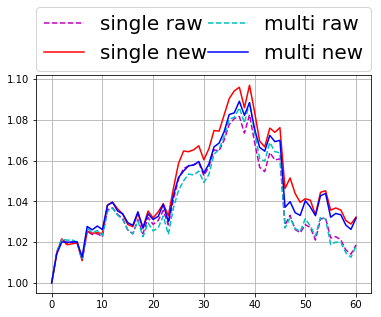

In [319]:
plt.plot(range(len(single_raw_result)), single_raw_result/10000, 'm--', label='single raw')
plt.plot(range(len(single_new_result)), single_new_result/10000, 'r-', label='single new')
plt.plot(range(len(single_raw_result)), np.array(lr_raw_result)/10000, 'c--', label='multi raw')
plt.plot(range(len(single_new_result)), np.array(lr_new_result)/10000, 'b-', label='multi new')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., fontsize=20)
plt.grid(True)
plt.savefig('profit_2016', bbox_inches = 'tight')